FOR 3 SECONDS, SAMPLING RATE = 6000

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data science and mathematical operations
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa
import IPython
import IPython.display as ipd

from keras.layers import Dense, Dropout, Input, ReLU
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras import models

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/genres_original'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
epochs = 100
batch_size = 32
sample_interval = 1
latent_dim = 100

In [ ]:
import os
import numpy as np
from scipy.io import wavfile

# Audio Config
DURATION = 3
SAMPLE_RATE = 6000
AUDIO_SHAPE = SAMPLE_RATE * DURATION

# Paths
DATASET_PATH = "/content/drive/MyDrive/genres_original/classical"

# Load train data
def load_train_data(label=None, input_length=AUDIO_SHAPE):
    train_files = os.listdir(DATASET_PATH)
    cur_batch_size = len(train_files)
    X = np.empty((cur_batch_size, input_length))
    for i, train_fname in enumerate(train_files):
        file_path = os.path.join(DATASET_PATH, train_fname)

        # Read and Resample the audio
        _, data = wavfile.read(file_path)
        if len(data) != input_length:
            data = np.interp(np.linspace(0, len(data) - 1, input_length), np.arange(len(data)), data)

        X[i,] = data
    print("Data Loaded...")
    return X

# Standardize Data
def normalization(X):
    mean = X.mean(axis=0, keepdims=True)
    std = X.std(axis=0, keepdims=True)
    X = (X - mean) / std
    print("Data Normalized...")
    return X

# Rescale Data to be in range [rangeMin, rangeMax]
def rescale(X, rangeMin=-1, rangeMax=+1):
    maxi = X.max()
    mini = X.min()
    X = np.interp(X, (mini, maxi), (rangeMin, rangeMax))
    print("Data Rescaled...")
    return X

if __name__ == "__main__":
    # Load all data from the "classical" directory
    train_data = normalization(load_train_data(input_length=AUDIO_SHAPE))


Data Loaded...
Data Normalized...


In [ ]:
train_data = normalization(load_train_data(AUDIO_SHAPE))

Data Loaded...
Data Normalized...


In [ ]:
x_train = rescale(train_data)


Data Rescaled...


In [ ]:
audio_samples = [x_train[0], x_train[2], x_train[10], x_train[20], x_train[42]]

for audio in audio_samples:
        IPython.display.display(ipd.Audio(data = audio, rate = SAMPLE_RATE))

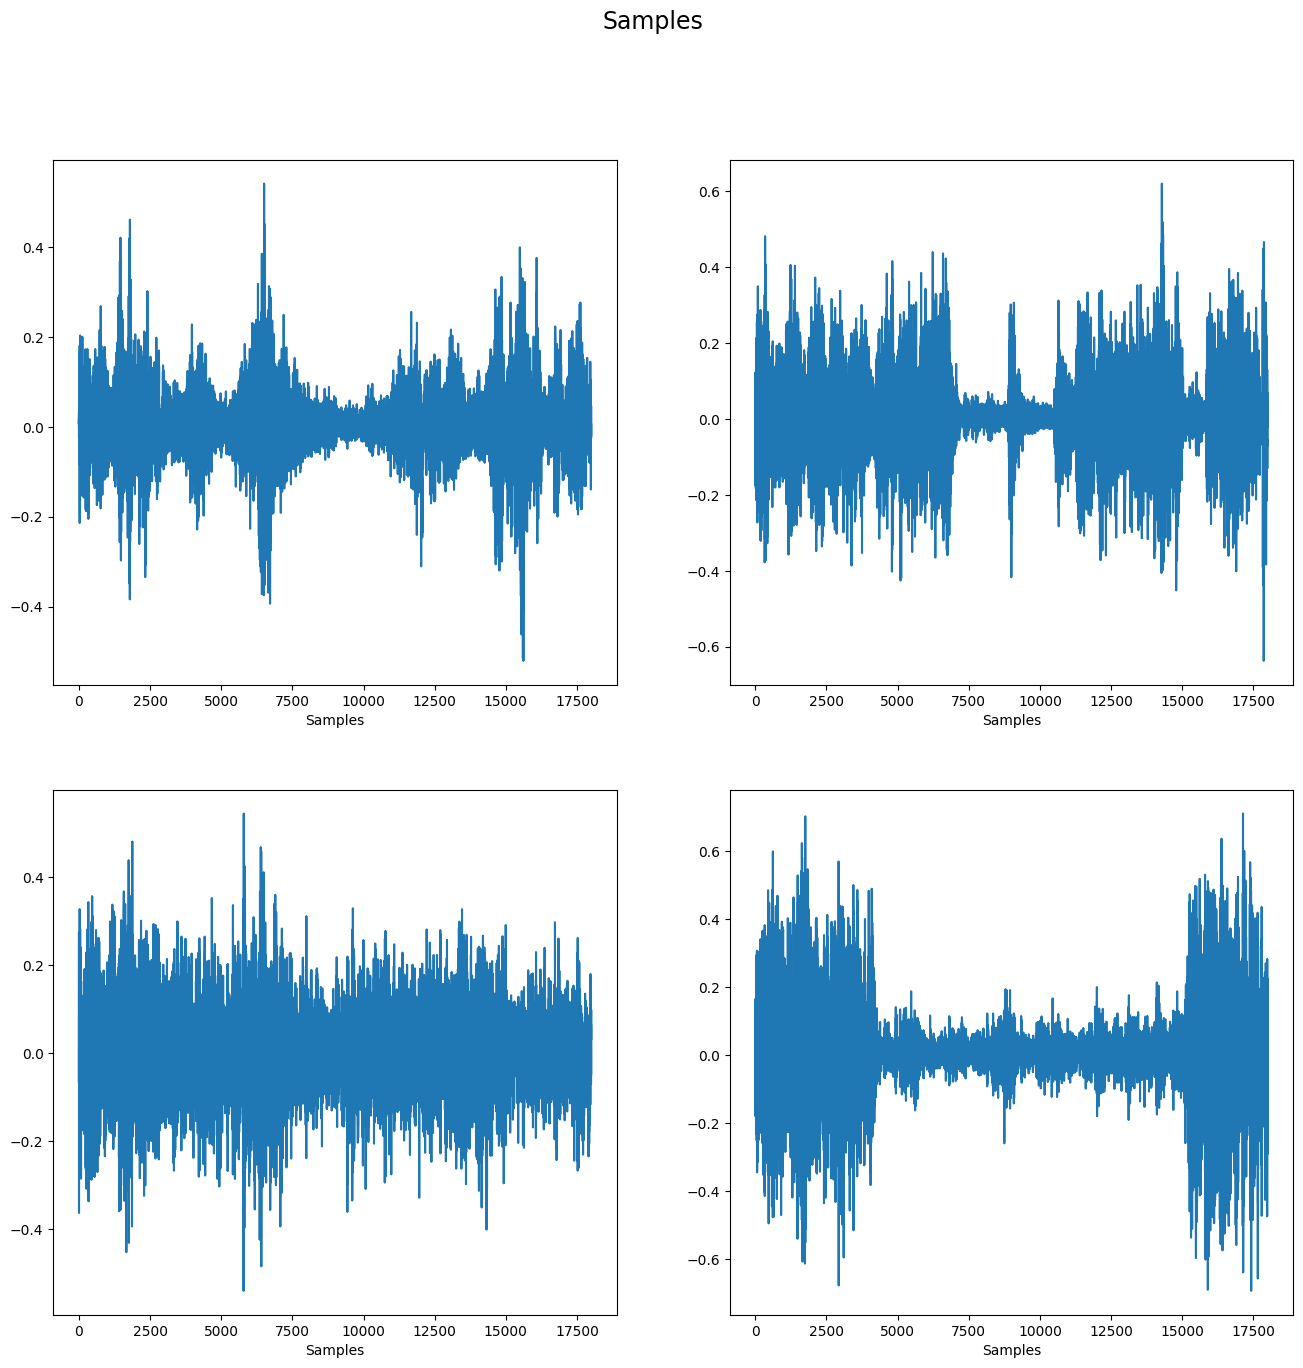

In [ ]:
length_of_audio_samples = len(audio_samples)
fig, ax = plt.subplots(int(length_of_audio_samples/2),2, figsize = (16,length_of_audio_samples*3))

# drwing plots
count = 0
for r in range(0,int(length_of_audio_samples/2)):
    for c in range(0,2):
        sample = audio_samples[count]
        ax[r,c].plot(sample)
        count += 1
        ax[r,c].set_xlabel("Samples")

fig.suptitle("Samples", fontsize = 17)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Define the generator
def build_generator(latent_dim, audio_shape):
    model = models.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(2048))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(4096))  # Adjusted to be a power of 2
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(audio_shape, activation='tanh'))  # Output layer
    return model

# Example usage:
latent_dim = 100  # Dimensionality of the latent space (input)
audio_shape = 18000  # For example, to generate 3 seconds of audio at a sample rate of 6kHz
generator = build_generator(latent_dim, audio_shape)

# Compile the generator
generator.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.0001, beta_1=0.5))

# Check the generator's architecture
generator.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 256)               25856     
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 256)               0         
                                                                 
 batch_normalization_20 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dense_37 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 512)               0         
                                                                 
 batch_normalization_21 (Ba  (None, 512)               2048      
 tchNormalization)                                    

In [ ]:
from tensorflow.keras.optimizers import Adam

# Define the discriminator
def build_discriminator(audio_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=(audio_shape,)))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Example usage:
audio_shape = 18000  # Assuming the same audio shape as your generator
discriminator = build_discriminator(audio_shape)

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

# Check the discriminator's architecture
discriminator.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 512)               9216512   
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_43 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_44 (Dense)            (None, 128)               32896     
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 128)               0         
                                                                 
 dropout_9 (Dropout)         (None, 128)              

In [ ]:
# Define the dimensions
latent_dim = 100  # Dimensionality of the latent space
AUDIO_SHAPE = 18000  # This should be defined somewhere in your script as the shape of the audio

# Build and compile the discriminator
discriminator = build_discriminator(audio_shape=AUDIO_SHAPE)  # Corrected parameter name
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the generator
generator = build_generator(latent_dim, audio_shape)

# Define the combined GAN model
def build_gan(generator, discriminator):
    # Make the discriminator not trainable when we are training the generator
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)  # Add the generator
    model.add(discriminator)  # Add the discriminator
    return model

# Build and compile the GAN model
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Print model summaries
print("Generator Summary:")
generator.summary()
print("\nDiscriminator Summary:")
discriminator.summary()
print("\nGAN Summary:")
gan.summary()


Generator Summary:
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 256)               25856     
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 256)               0         
                                                                 
 batch_normalization_25 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dense_51 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 512)               0         
                                                                 
 batch_normalization_26 (Ba  (None, 512)               2048      
 tchNormalization)                

In [ ]:
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)  # discriminator(generator(Input(100,)))
    gan = Model(inputs = gan_input, outputs = gan_output)
    gan.compile(loss = "binary_crossentropy", optimizer = "adam")
    return gan

gan = create_gan(discriminator, generator)
gan.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_11 (Sequential)  (None, 18000)             84952400  
                                                                 
 sequential_10 (Sequential)  (None, 1)                 9380865   
                                                                 
Total params: 94333265 (359.85 MB)
Trainable params: 84936528 (324.01 MB)
Non-trainable params: 9396737 (35.85 MB)
_________________________________________________________________


In [ ]:
def show_gen_samples(epochs, samples = 3):
    samplePlot = []
    fig        = plt.figure(figsize = (1, samples))
    noise      = np.random.normal(0, 1, (samples,100))
    audios     = g.predict(noise)
    for i, audio in enumerate(audios):
        IPython.display.display(ipd.Audio(data = audio, rate = SAMPLE_RATE))
        samplePlot.append(fig.add_subplot(1, samples, i+1))
        samplePlot[i].plot(audio.flatten(), '-', )  # remove this section and do not display audio at every step.
    plt.gcf().set_size_inches(25, 5)
    plt.subplots_adjust(wspace=0.3,hspace=0.3)
    fig.suptitle("{} Epochs Result".format(epochs), fontsize = 17)
    plt.show()

1/1 [==============================] - 0s 150ms/step


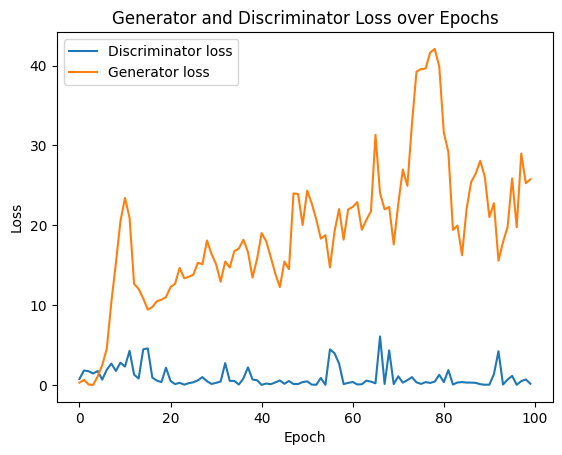

In [ ]:
# Define a function to train the GAN and return loss values
def train_gan(generator, discriminator, gan, train_data, epochs, batch_size, sample_interval):
    # Reshape the data for training
    train_data = train_data.reshape(train_data.shape[0], -1)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    # Lists to store loss values for plotting
    d_loss_list = []
    g_loss_list = []

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of real audio samples
        idx = np.random.randint(0, train_data.shape[0], batch_size)
        real_samples = train_data[idx]

        # Generate a batch of fake audio samples
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_samples = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_samples, valid)
        d_loss_fake = discriminator.train_on_batch(gen_samples, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Generate a batch of noise vectors
        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Train the generator (to have the discriminator label samples as valid)
        g_loss = gan.train_on_batch(noise, valid)

        # Save loss values for plotting
        d_loss_list.append(d_loss[0])
        g_loss_list.append(g_loss)

    # Return the loss values
    return d_loss_list, g_loss_list

# Train the GAN and get loss values
d_loss_values, g_loss_values = train_gan(generator, discriminator, gan, train_data, epochs, batch_size, sample_interval)

# Plot the generator and discriminator loss values
plt.plot(range(epochs), d_loss_values, label="Discriminator loss")
plt.plot(range(epochs), g_loss_values, label="Generator loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Generator and Discriminator Loss over Epochs")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio

# Define a function to generate and play audio samples
def generate_and_play_samples(generator, num_samples=3, latent_dim=100, sample_length=6000):
    # Generate random noise as input to the generator
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    # Generate audio samples using the generator
    gen_samples = generator.predict(noise)

    # Play each generated audio sample
    for i in range(num_samples):
        # Convert audio sample to a playable format
        audio_sample = gen_samples[i].reshape(-1)
        # Play the audio sample
        display(Audio(audio_sample, rate=6000))

# Generate and play audio samples
generate_and_play_samples(generator)


1/1 [==============================] - 0s 141ms/step
